# Generating composite images  <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)


## Background

Individual remote sensing images can be affected by noisy data, including clouds, cloud shadows, and haze. 
To produce cleaner images that can be compared more easily across time, we can create 'summary' images or 'composites' that combine multiple images into one.

Some methods for generating composites include estimating the `median`, `mean`, `minimum`, or `maximum` pixel values in an image.
Care must be taken with these, as they do not necessarily preserve spectral relationships across bands. 
To learn how to generate a composite that does preserve these relationships, see the [Generating geomedian composites notebook](Generating_geomedian_composites.ipynb).

## Description
This notebook demonstrates how to generate a number of different composites from satellite images, and discusses the uses of each.
Specifically, this notebook demonstrates how to generate:

1. Median composites
2. Mean composites
3. Minimum and maximum composites
4. Nearest-time composites

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import xarray as xr

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard, first, last, nearest
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import rgb


/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Generating_composites')

## Load Landsat 8 data

Here we load a timeseries of cloud-masked Landsat 8 satellite images through the datacube API using the [load_ard](Using_load_ard.ipynb) function.

In [3]:
# Set the area of interest
lat, lon = -12.25, 132.40
buffer = 0.07

# Create a reusable query
query = {
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'time': ('2018-01', '2018-12'),
    'measurements': ['nbart_green',
                     'nbart_red',
                     'nbart_blue',
                     'nbart_nir'],
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'output_crs':'EPSG:3577'
}

# Load available data
ds = load_ard(dc=dc,
              products=['ga_ls8c_ard_3'],
              **query)

# Print output data
ds


Finding datasets
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Loading 23 time steps


<xarray.Dataset>
Dimensions:      (time: 23, x: 520, y: 509)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-04T01:16:45.170611 ... 2018-12...
  * y            (y) float64 -1.284e+06 -1.284e+06 ... -1.299e+06 -1.299e+06
  * x            (x) float64 3.656e+04 3.658e+04 ... 5.21e+04 5.212e+04
    spatial_ref  int32 3577
Data variables:
    nbart_green  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_red    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_blue   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Plot timesteps in true colour

To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a series of timesteps. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

The code below will plot three timesteps of the time series we just loaded:

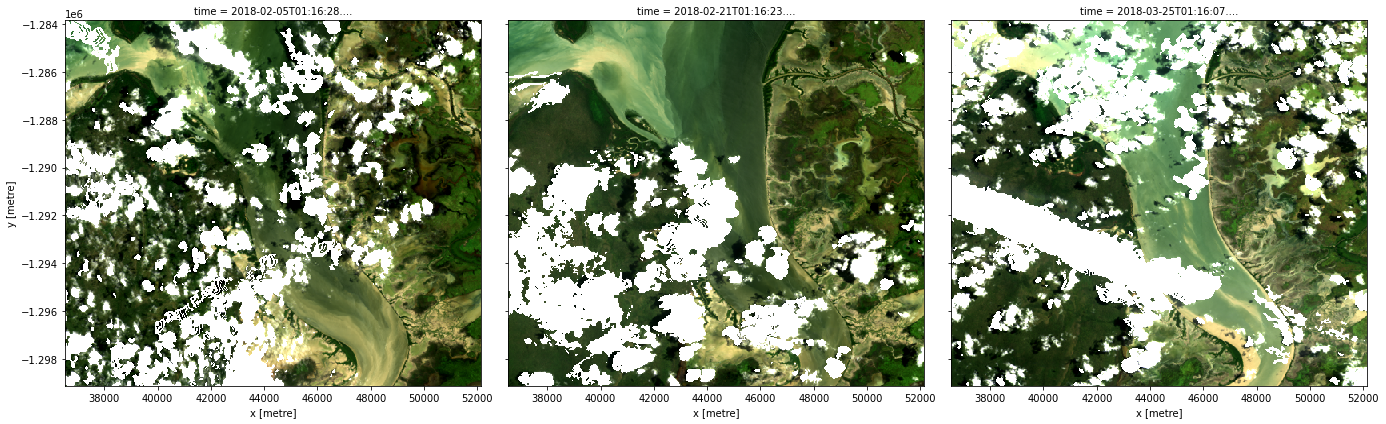

In [4]:
# Set the timesteps to visualise
timesteps =  [2, 3, 5]

# Generate RGB plots at each timestep
rgb(ds, index=timesteps)

## Median composites

One of the key reasons for generating a composite is to replace pixels classified as clouds with realistic values from the available data. 
This results in an image that doesn't contain any clouds.
In the case of a median composite, each pixel is selected to have the median (or middle) value out of all possible values.

Care should be taken when using these composites for analysis, since the relationships between spectral bands are not preserved.
These composites are also affected by the timespan they're generated over.
For example, the median pixel in a single season may be different to the median value for the whole year.

> **Note:** For an advanced compositing method that maintains spectral relationships between satellite bands, refer to the [Generating geometric median composites](./Generating_geomedian_composites.ipynb) notebook.

### Generating a single median composite from all data

To generate a single median composite, we use the `xarray.median` method, specifying `'time'` as the dimension to compute the median over.

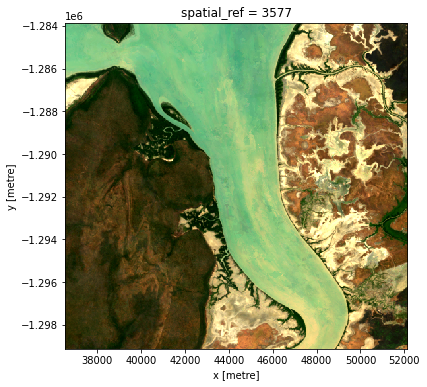

In [5]:
# Compute a single median from all data
ds_median = ds.median('time')

# View the resulting median
rgb(ds_median)

### Generating multiple median composites based on length of time
Rather than using all the data to generate a single median composite, it's possible to use the `xarray.resample` method to group the data into smaller time-spans and generate medians for each of these.
Some resampling options are
* `'nD'` - number of days (e.g. `'7D'` for seven days)
* `'nM'` - number of months (e.g. `'6M'` for six months)
* `'nY'` - number of years (e.g. `'2Y'` for two years)

If the area is particularly cloudy during one of the time-spans, there may still be masked pixels that appear in the median.
This will be true if that pixel is always masked.

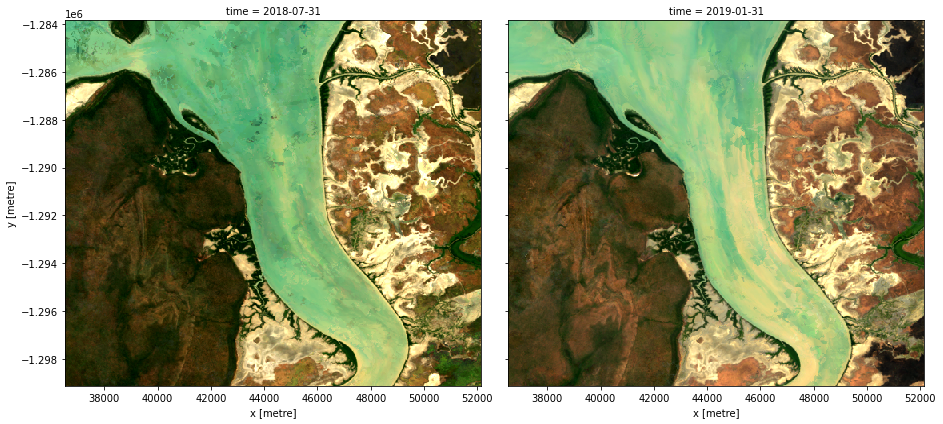

In [6]:
# Generate a median by binning data into six-monthly time-spans
ds_resampled_median = ds.resample(time='6M').median('time')

# View the resulting medians
rgb(ds_resampled_median, index=[1, 2])

### Group By
Similar to resample, grouping works by looking at part of the date, but ignoring other parts. For instance, `'time.month'` would group together all January data together, no matter what year it is from.

Some examples are:
 * `'time.day'` - groups by the day of the month (1-31)
 * `'time.dayofyear'` - groups by the day of the year (1-365)
 * `'time.week'` - groups by week (1-52) 
 * `'time.month'` - groups by the month (1-12)
 * `'time.season'` - groups into 3-month seasons:
     - `'DJF'` December, Jaunary, February
     - `'MAM'` March, April, May
     - `'JJA'` June, July, August
     - `'SON'` September, October, November
 * `'time.year'` - groups by the year

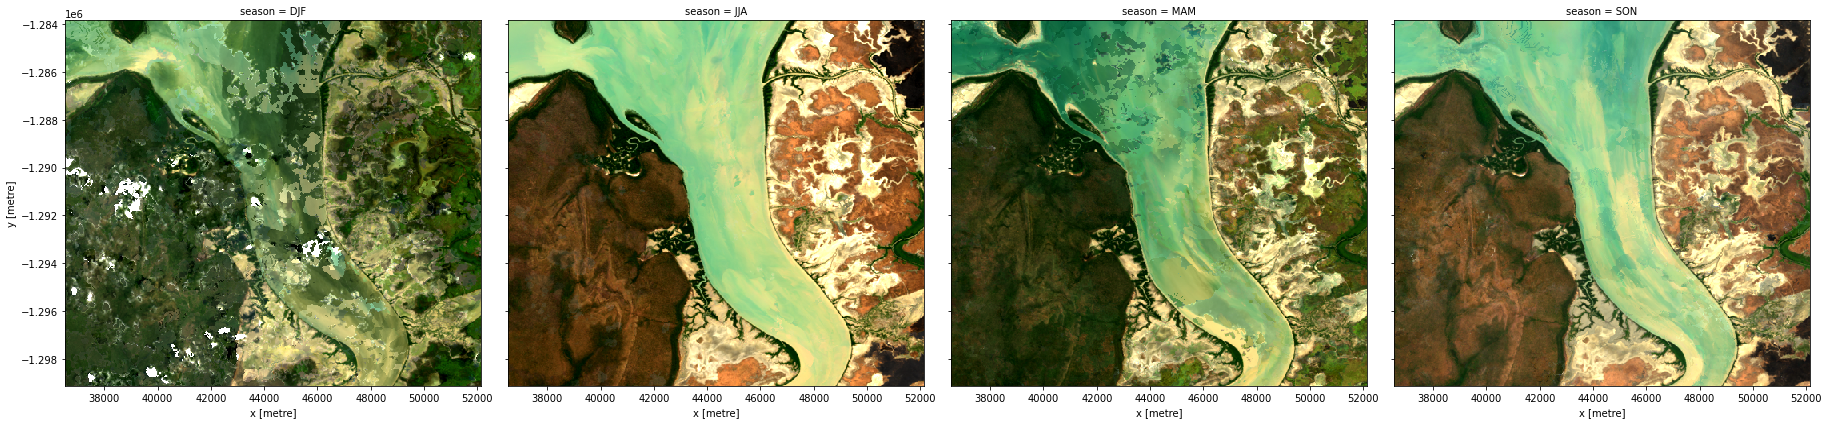

In [7]:
# Generate a median by binning data into six-monthly time-spans
ds_groupby_season = ds.groupby('time.season').median()

# View the resulting medians
rgb(ds_groupby_season, col='season')

## Mean composites

Mean composites involve taking the average value for each pixel, rather than the middle value as is done for a median composite.
Unlike the median, the mean composite can contain pixel values that were not part of the original dataset.
Care should be taken when interpreting these images, as extreme values (such as unmasked cloud) can strongly affect the mean.

### Generating a single mean composite from all data

To generate a single mean composite, we use the `xarray.mean` method, specifying `'time'` as the dimension to compute the mean over.

> **Note**: If there are no valid values for a given pixel, you may see the warning:
`RuntimeWarning: Mean of empty slice`. The composite will still be generated, but may have blank areas.

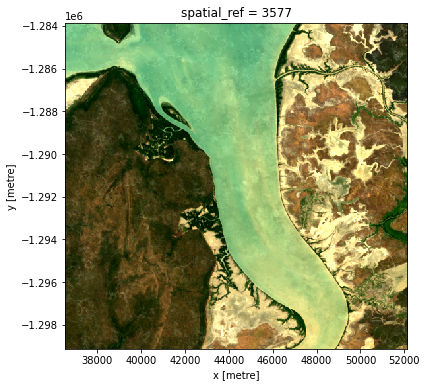

In [8]:
# Compute a single mean from all data
ds_mean = ds.mean('time')

# View the resulting mean
rgb(ds_mean)

### Generating multiple mean composites based on a length of time
As with the median composite, it's possible to use the `xarray.resample` method to group the data into smaller time-spans and generate means for each of these.
See the previous section for some example resampling time-spans.

> **Note:** If you get the warning `RuntimeWarning: Mean of empty slice`, this just means that for one of your groups there was at least one pixel that contained all `nan` values.

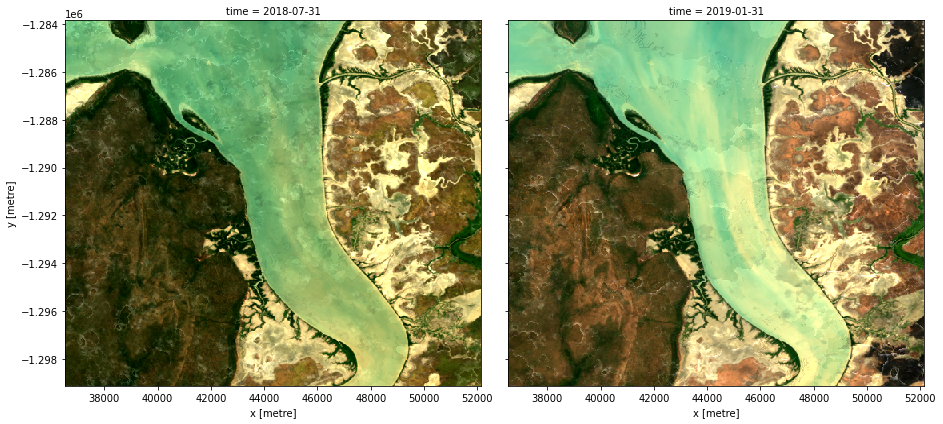

In [9]:
# Generate a mean by binning data into six-monthly time-spans
ds_resampled_mean = ds.resample(time='6M').mean('time')

# View the resulting medians
rgb(ds_resampled_mean, index=[1,2])

## Minimum and maximum composites

These composites can be useful for identifying extreme behaviour in a collection of satellite images.

For example, comparing the maximum and minimum composites for a given band index could help identify areas that take on a wide range of values, which may indicate areas that have high variability over the time-line of the composite.

To demonstrate this, we start by calculating the normalised difference vegetation index (NDVI) for our data, which can then be used to generate the maximum and minimum composites.

In [10]:
# Start by calculating NDVI
ds = calculate_indices(ds, index='NDVI', collection='ga_ls_3')

### Maximum composite

To generate a single maximum composite, we use the `xarray.max` method, specifying `'time'` as the dimension to compute the maximum over.

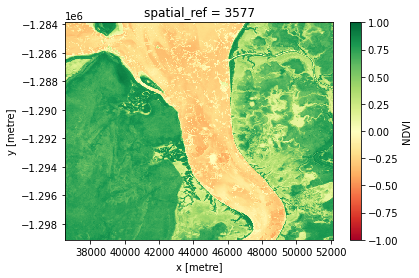

In [11]:
# Compute the maximum composite
da_max = ds.NDVI.max('time')

# View the resulting composite
da_max.plot(vmin=-1, vmax=1, cmap='RdYlGn');

### Minimum composite

To generate a single minimum composite, we use the `xarray.min` method, specifying `'time'` as the dimension to compute the minimum over.

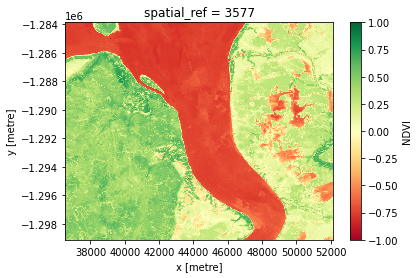

In [12]:
# Compute the minimum composite
da_min = ds.NDVI.min('time')

# View the resulting composite
da_min.plot(vmin=-1, vmax=1, cmap='RdYlGn');

## Nearest-time composites

To get an image at a certain time, often there is missing data, due to clouds and other masking.  We can fill in these gaps by using data from surrounding times.

To generate these images, we can use the custom functions `first`, `last` and `nearest` from the [dea_datahandling](../Scripts/dea_datahandling.py#716) script.

You can also use the in-built `.first()` and `.last()` methods when doing `groupby` and `resample` as described above. They are described in the [xarray documentation](http://xarray.pydata.org/en/stable/groupby.html#first-and-last) on grouped data.

### Most-recent composite

Sometime we may want to determine what the landscape looks like by examining the most recent image.  If we look at the last image for our dataset, we can see there is lots of missing data in the last image.

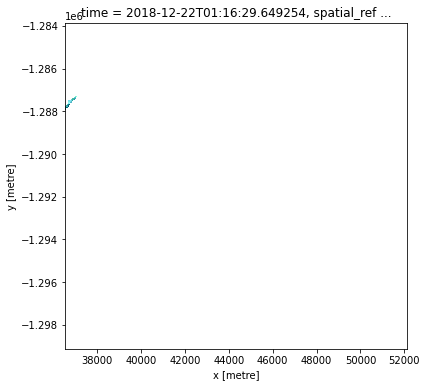

In [13]:
# Plot the last image in time
rgb(ds, index=-1)

We can calculate how much of the data is missing in this most recent image

In [14]:
last_blue_image = ds.nbart_blue.isel(time=-1)

precent_valid_data = float(last_blue_image.count() / 
                           last_blue_image.size) * 100
print(f'The last image contains {precent_valid_data:.2f}% data.')

The last image contains 0.04% data.


In order to fill in the gaps and produce a complete image showing the most-recent satellite acquistion for every pixel, we can run the `last` function on one of the arrays.
This will return the most recent cloud-free value that was observed by the satellite for every pixel in our dataset.

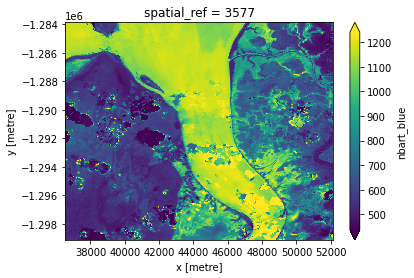

In [15]:
last_blue = last(ds.nbart_blue, dim='time')
last_blue.plot(robust=True);

To see how recent each pixel is, we can compare the age of the pixels with the latest value we have.

Here we can see that most pixels were from the last few time slices, although there are some that were much older.

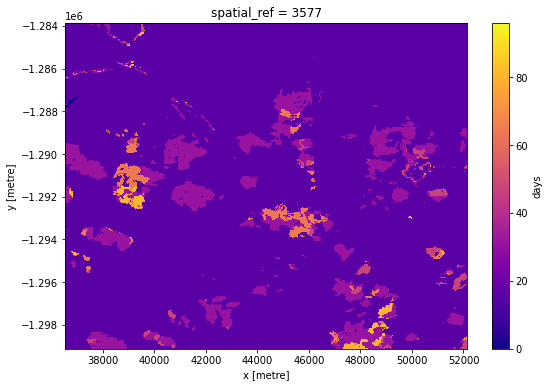

In [16]:
# Identify latest time in our data
last_time = last_blue.time.max()

# Compare the timestamps and convert them to number of days for plotting.
num_days_old = (last_time - last_blue.time).dt.days
num_days_old.plot(cmap='plasma', size=6);

We can run this method on all of the bands. 
However we only want pixels that have data in every band. 
On the edges of a satellite pass, some bands don't have data.

To get rid of pixels with missing data, we will convert the dataset to an array, and select only those pixels with data in all bands.

In [17]:
# Convert to array
da = ds.to_array(dim='variable')

# Create a mask where data has no-data
no_data_mask = da.isnull().any(dim='variable')

# Mask out regions where there is no-data
da = da.where(~no_data_mask)

Now we can run the `last` function on the array, then turn it back into a dataset. 

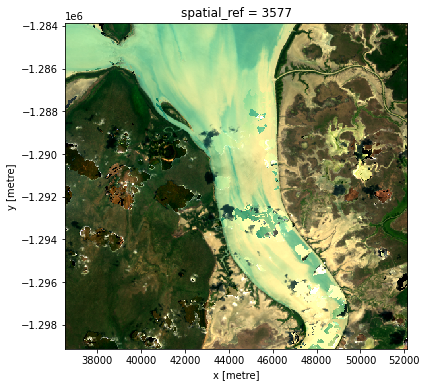

In [18]:
da_latest = last(da, dim='time')

ds_latest = da_latest.to_dataset(dim='variable').drop_dims('variable')

# View the resulting composite
rgb(ds_latest)

### Before and after composites

Often it is useful to view images before and after an event, to see the change that has occured.

To generate a composite on either side of an event, we can split the dataset along time.

We can then view the composite `last` image before the event, and the composite `first` image after the event.

In [19]:
# Dates here are inclusive. Use None to not set a start or end of the range.
before_event = slice(None, '2018-06-01')
after_event = slice('2018-06-03', None)

# Select the time period and run the last() or first() function on every band.
da_before = last(da.sel(time=before_event), dim='time')
da_after = first(da.sel(time=after_event), dim='time')

# Convert both DataArrays back to Datasets for plotting
ds_before = da_before.to_dataset(dim='variable').drop_dims('variable')
ds_after = da_after.to_dataset(dim='variable').drop_dims('variable')

The composite image before the event, up to `2019-06-01`:

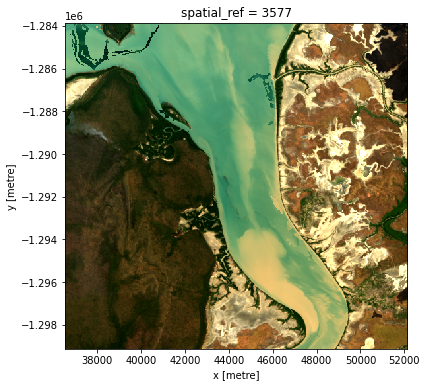

In [20]:
rgb(ds_before)

The composite image after the event, from `2019-06-03` onward:

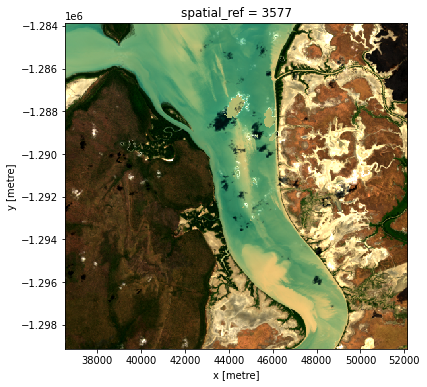

In [21]:
rgb(ds_after)

### Nearest time composite

Sometimes we just want the closest available data to a particular point in time. 
This composite will take values from before _or_ after the specified time to find the nearest observation to our target time:

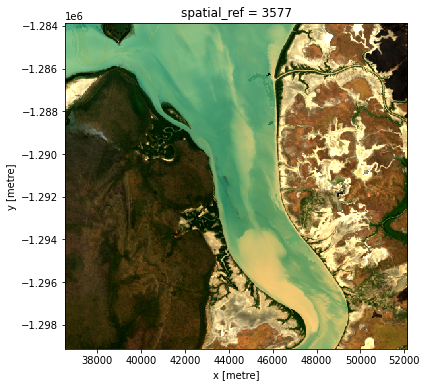

In [22]:
# Generate nearest time composite
da_nearest = nearest(da, dim='time', target='2018-06-03')

# Plot nearest time composite
ds_nearest = da_nearest.to_dataset(dim='variable').drop_dims('variable')
rgb(ds_nearest)

By looking at the `time` for each pixel, we can see if the pixel was taken from before or after the target time.

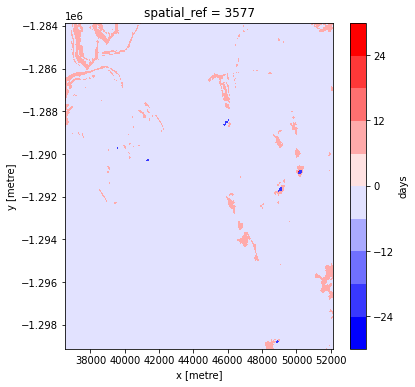

In [23]:
target_datetime = da_nearest.time.dtype.type('2018-06-03')

# Calculate different in times and convert to number of days
num_days_different = (da_nearest.time.min(dim='variable') - target_datetime).dt.days

# Plot days before or after target date
num_days_different.plot(cmap='bwr', levels=11, figsize=(6, 6));

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [24]:
print(datacube.__version__)

1.8.5


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)